In [5]:
import pathlib
import os
if not "changed_working_directory" in locals():
    changed_working_directory = True
    os.chdir(pathlib.Path().resolve().parent)
    
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

import os
from math import ceil

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate, LeakyReLU, ReLU, Embedding, Activation

from IPython.display import clear_output, display

import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfd = tfp.distributions
from tabGAN import TabGAN
from src import constants as const

imports_path = "src//imports.ipynb"

%run "$imports_path"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


KeyboardInterrupt: 

KeyboardInterrupt: 

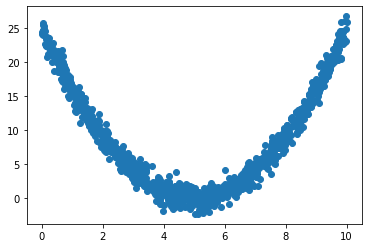

In [8]:
n_train = 1000
x1 = np.random.uniform(0, 10, n_train)
x2 = np.random.normal((x1-5)**2, 1, n_train)
#dummy = np.random.randint(0, 2, size = n_train).astype(str)
dummy = "dummy"
data_toy = pd.DataFrame({"x1" : x1, "x2" : x2, "dummy" : dummy})
plt.scatter(data_toy["x1"], data_toy["x2"])

In [ ]:
tgt = TabGAN(data_toy, adam_beta1=0.6, n_critic=10, jit_compile=True)
# 200, n_critic = 10, quantile_transformation_int = False, opt_lr = 0.0002, adam_beta1=0.5,
#              jit_compile=True)
fig_l, fig_2D = tgt.train(1000, plot2D_image = True, plot2D_image_real_time=True, plot_loss = True, progress_bar=True)

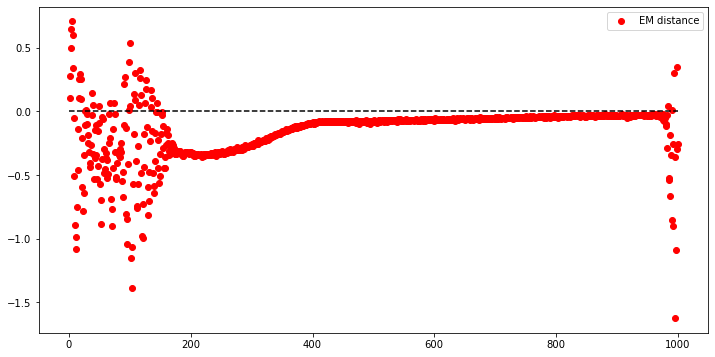

In [11]:
fig_l

In [10]:
tgt.generate_data()

,x1,x2,dummy
0,9.904194,18.931864,dummy
1,8.343863,9.997717,dummy
2,7.729160,4.639312,dummy
3,7.663661,8.941900,dummy
4,4.072011,-0.983365,dummy
...,...,...,...
995,10.192389,20.897400,dummy
996,9.933918,19.794142,dummy
997,7.852861,5.144573,dummy
998,3.986590,1.691075,dummy


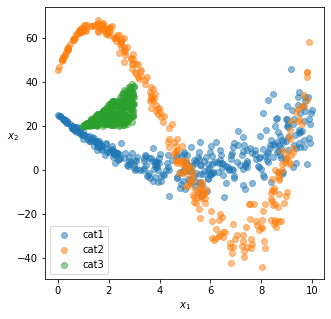

In [21]:
from utils.plot.helpers import _map_str_to_color
n_train = 2500

x1 = np.random.uniform(0, 10, n_train)

labels = np.core.defchararray.add("cat", np.random.randint(1,4, n_train).astype(str))
label_value, counts = np.unique(labels, return_counts =True)
index_end = np.cumsum(counts)
index_start = np.append([0], index_end[:len(index_end)-1])
x1 = np.empty(n_train)
x2 = np.empty(n_train)

for i in range(len(label_value)):
    if label_value[i] in ["cat1", "cat2"]:
        x1_curr = np.random.uniform(0, 10, counts[i])
        x2_curr = np.random.normal(np.where(label_value[i] == "cat1", (x1_curr-5)**2, (x1_curr+1) * (x1_curr-5) * (x1_curr-9)),
                      x1_curr, counts[i])
    elif label_value[i] == "cat3":
        x1_curr = np.random.uniform(1,3, counts[i])
        x2_curr = np.random.uniform(20, (x1_curr - 1) * 10 + 20, counts[i])
    else:
        print("Something wrong")
        
    x1[index_start[i]:index_end[i]] = x1_curr
    x2[index_start[i]:index_end[i]] = x2_curr
    labels[index_start[i]:index_end[i]] = label_value[i]

fig, ax = plt.subplots(1, figsize=(5,5))
data_toy2 = pd.DataFrame({"x1" : x1, "x2" : x2, "labels" : labels.astype(str)})
labels_unique = np.unique(data_toy2["labels"])
colors = _map_str_to_color(labels_unique, color_map=None)
data_toy2_fewer_observations = data_toy2.iloc[np.random.choice(data_toy2.shape[0], size=1000, replace=False), :]
for i, lab in enumerate(labels_unique):
    data_toy2_subset = data_toy2_fewer_observations.loc[data_toy2["labels"] == lab]
    plt.scatter(data_toy2_subset["x1"], data_toy2_subset["x2"], color = colors[i], alpha=0.5,
           label = lab)
plt.legend()
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$", rotation = 0)
plt.savefig(os.path.join(const.dir.images(), "syn2D_3cats.pdf"))

In [16]:
def get_tabGAN_dict(ctgan, simple=False):
    tabGAN_name = ""
    if ctgan:
        tabGAN_name += "c"
    tabGAN_name += "tabGAN"
    dict_tabGAN = {
        "batch_size": 500,
        "ctgan": ctgan,
        "n_critic":10,
        "pac":1,
        "optimizer":"adam",
        "opt_lr":0.0002,
        "qtr_spread":1,
        "adam_beta1":0.7,
        "adam_beta2":0.999,
        "qtr_lbound_apply":0.05,
        "jit_compile":True,
        "wgan_lambda":10,
        "quantile_transformation_int":False,
        "quantile_rand_transformation":False,
        "noise_discrete_unif_max":0 if ctgan else 0.01,
        "gumbel_temperature":0.5 if ctgan else 0.1,
        "activation_function":"GELU",
        "max_quantile_share":1,
        "n_quantiles_int":1000,
        "qt_n_subsample":1e5,
        "dim_hidden":256,
        "dim_latent":128,
        "tf_data_use":(not ctgan),
        "ctgan_binomial_loss":True,
        "ctgan_log_frequency":True,
        "train_step_critic_same_queries_for_critic_and_gen":True,
        "train_step_critic_wgan_penalty_query_diversity":False,
        "train_step_critic_query_wgan_penalty":True,
        "critic_use_query_input":True,
        "batch_normalization_generator":False,
        "batch_normalization_before_activation":False,
        "generator_concatenate_hidden_with_previous_layer":False,
        "layer_normalization_critic":False,
        "layer_normalization_simple_type":False,
        "layer_normalization_before_activation":False,
        "qt_distribution":"normal",
        "latent_distribution":"normal",
        "oh_encoding_activation_function":"gumbel"
    }
    if simple:
        tabGAN_name += "-simple"
        dict_tabGAN["activation_function"] : "LeakyReLU"
        dict_tabGAN["batch_normalization_generator"] : False
        dict_tabGAN["noise_discrete_unif_max"] : 0
        
    dict_tabGAN_train = {
        "n_epochs": 10000,
        "save_dir" : const.dir.images(),
        "plot2D_image_real_time":True,
        "plot2D_image" : True,
        "filename_plot2D" : f"syn2D_3cats_plot2D_{tabGAN_name}.pdf",
        "plot2D_discrete_col" : "labels",
        "plot2D_n_img_horiz" : 4,
        "plot2D_n_test" : 1000,
        "plot2D_color_map":None,
        "filename_plot_loss" : f"syn2D_3cats_train_loss_{tabGAN_name}.pdf",
        "plot_loss" : True,
        "plot_loss_type" : "line",
        "progress_bar": True
    }
    return dict_tabGAN, dict_tabGAN_train


In [50]:
# dict_tg_simple, dict_tg_simple_train = get_tabGAN_dict(ctgan=False, simple=True)
# tg_simple = TabGAN(data_toy2, **dict_tg_simple)
# fig2_l_tg_simple, fig2_2D_tg_simple = tg_simple.train(**dict_tg_simple_train)

In [51]:
# fig2_l_tg_simple

In [52]:
# dict_ctg_simple, dict_ctg_simple_train = get_tabGAN_dict(ctgan=True, simple=True)
# ctg_simple = TabGAN(data_toy2, **dict_ctg_simple)
# fig2_l_ctg_simple, fig2_2D_ctg_simple = ctg_simple.train(**dict_ctg_simple_train)

In [53]:
# fig2_l_ctg_simple

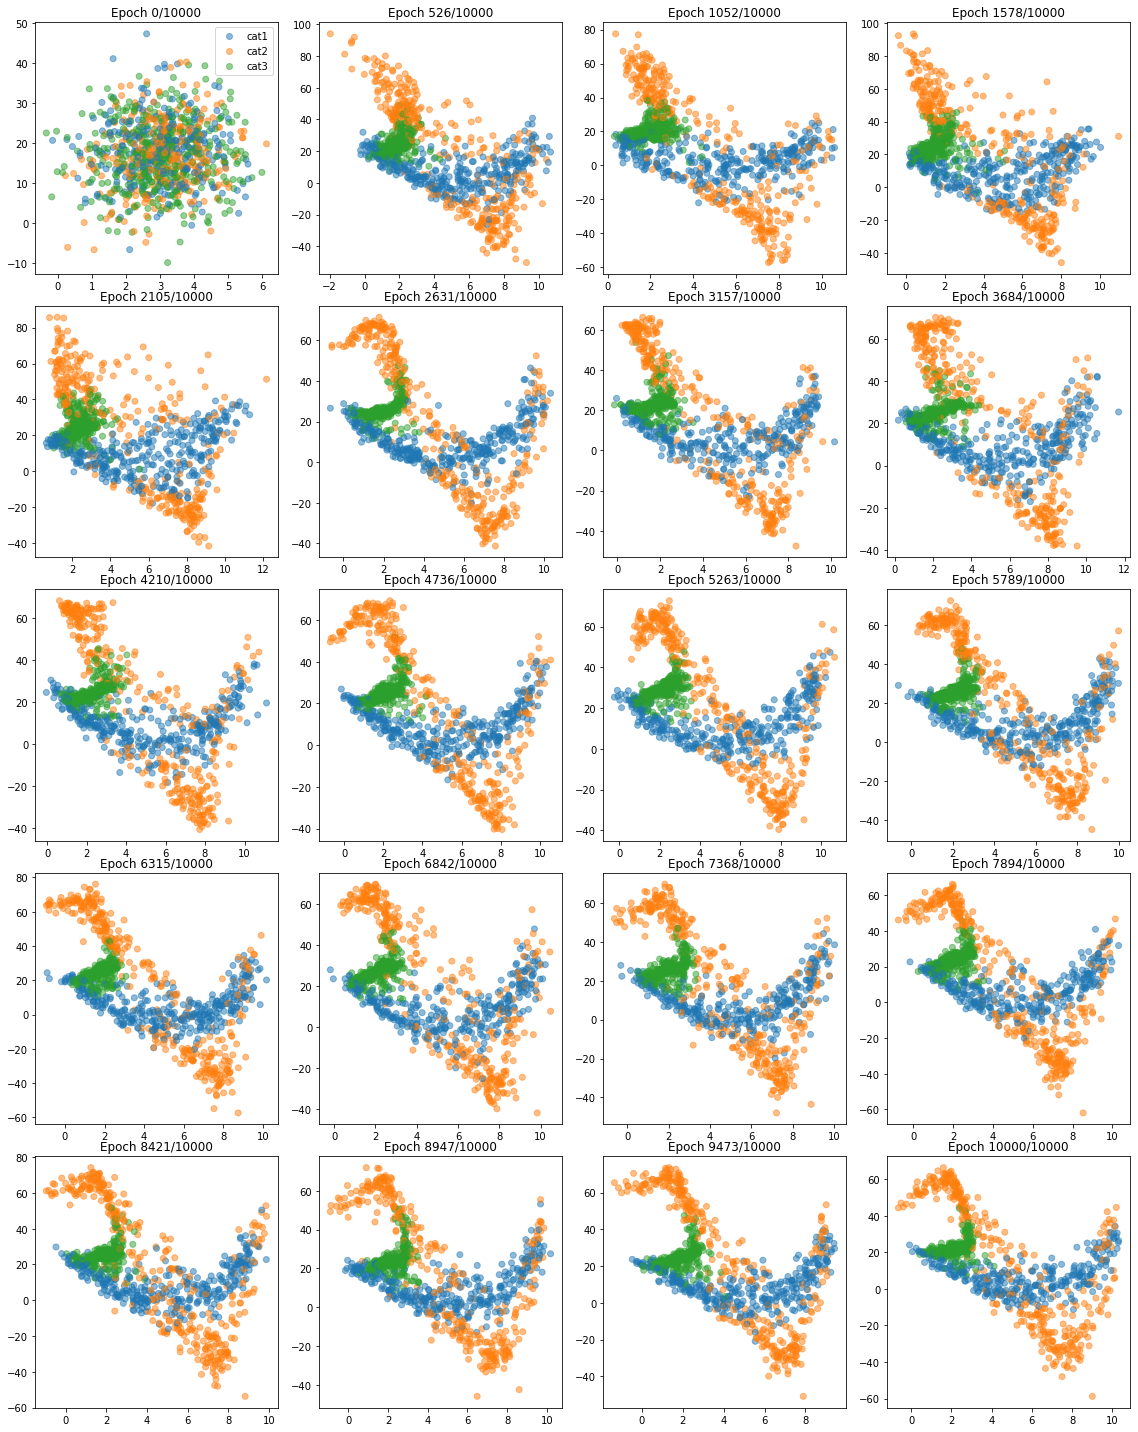

  0%|          | 0/10000 [00:00<?, ?it/s]

In [17]:
dict_tg, dict_tg_train = get_tabGAN_dict(ctgan=False, simple=False)
tg = TabGAN(data_toy2, **dict_tg)
fig2_l_tg, fig2_2D_tg = tg.train(**dict_tg_train)

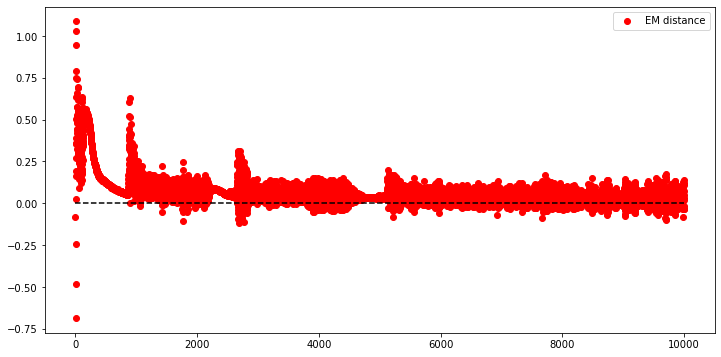

In [18]:
fig2_l_tg

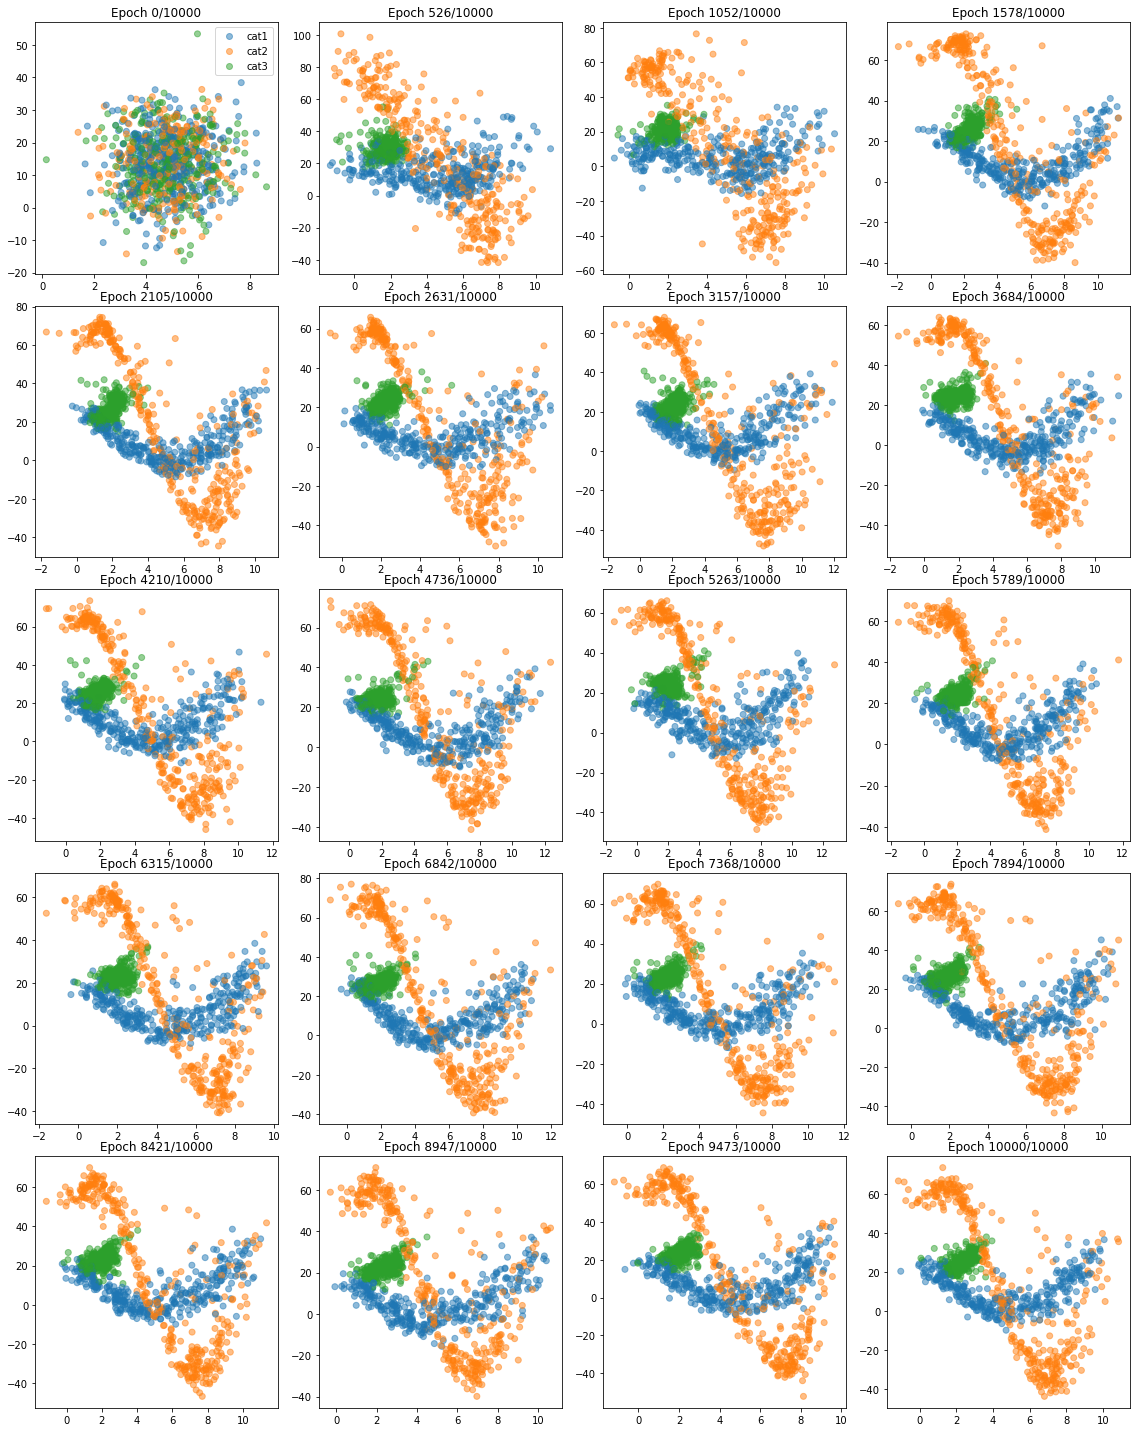

  0%|          | 0/10000 [00:00<?, ?it/s]

In [19]:
dict_ctg, dict_ctg_train = get_tabGAN_dict(ctgan=True, simple=False)
ctg = TabGAN(data_toy2, **dict_ctg)
fig2_l_ctg, fig2_2D_ctg = ctg.train(**dict_ctg_train)

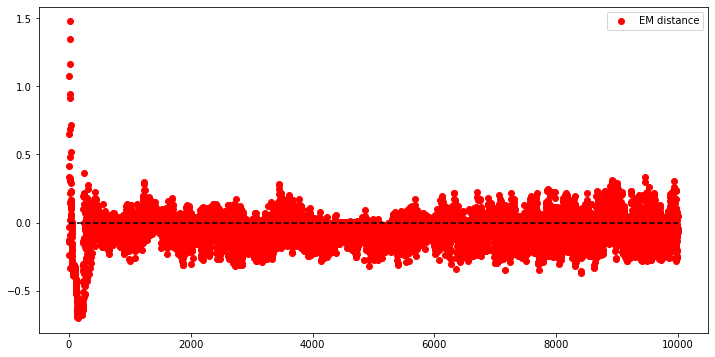

In [20]:
fig2_l_ctg